In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from os.path import join, basename, splitext
from tqdm import tqdm

import shutil



In [4]:
data_root = '../../data/m1766395'
os.path.isdir(data_root)

target_root = '../../data/m1766395_clean'
if not os.path.exists(target_root):
    os.makedirs(target_root)

In [86]:
# only copy non-empty mask files
def copy_non_zero(dir_path, target_path):
    print(dir_path)
    files = sorted(glob(join(dir_path, 'images/*.jpg')))
    files_mask = sorted(glob(join(dir_path, 'masks/*.png')))
    file_names = [splitext(basename(f))[0] for f in files]
    file_names_mask = [splitext(basename(f))[0] for f in files_mask]
    target_dir_image = join(target_path, 'images')
    target_dir_mask = join(target_path, 'masks')
    if not os.path.exists(target_dir_image):
        os.makedirs(target_dir_image)
    if not os.path.exists(target_dir_mask):
        os.makedirs(target_dir_mask)
    # check pairings
    assert (len(file_names) == len(file_names_mask))
    for f in file_names:
        assert(f in file_names_mask)
    for f, m in zip(files, files_mask):
        f_name = splitext(basename(f))[0]
        m_name = splitext(basename(m))[0]
        assert f_name == m_name
        mask_np = np.asarray(Image.open(m))
        if not np.max(mask_np) == 0:
            shutil.copy(f, target_dir_image)
            shutil.copy(m, target_dir_mask)
        



In [87]:
for source_dir in glob(join(data_root, '*')):
    if os.path.isdir(source_dir):
        folder_name = basename(source_dir)
        target_dir = join(target_root, folder_name)
        copy_non_zero(source_dir, target_dir)

../../data/m1766395/Hand-drawn
../../data/m1766395/CAD
../../data/m1766395/BIM


In [6]:
from matplotlib.colors import ListedColormap

# material classes
color_mapping = {
    (255, 0, 255): "Reinforced Concrete",
    (255, 135, 0): "Unreinforced Concrete",
    (0, 255, 36): "Precast Concrete",
    (25, 0, 255): "Masonry",
    (25, 124, 13): "Slit",
    (255, 250, 0): "XPS Insulation",
    (255, 0, 0): "Hard Insulation",
    (0, 235, 248): "Soft Insulation (Computer-Aided)",
    (147, 27, 236): "Soft Insulation (Hand-Drawn)",
    (0, 0, 0): "Non-Material"
}

color_to_class = {
    (255, 0, 249): 1,
    (255, 135, 0): 2,
    (0, 255, 36): 3,
    (25, 0, 255): 4,
    (25, 124, 13): 5,
    (255, 249, 0): 6,
    (255, 0, 0): 7,
    (0, 238, 255): 8,
    (147, 27, 236): 8,
    (0, 0, 0): 0
}

class_to_labels = {
    0: "Non-Material",
    1: "Reinforced Concrete",
    2: "Unreinforced Concrete",
    3: "Precast Concrete",
    4: "Masonry",
    5: "Slit",
    6: "XPS Insulation",
    7: "Hard Insulation",
    8: "Soft Insulation ",
}

# Get a single color for each class
# If a class has multiple RGBs (like class 8), just pick one
class_colors = {}
for rgb, class_id in color_to_class.items():
    if class_id not in class_colors:
        class_colors[class_id] = rgb

# Sort by class index
sorted_classes = sorted(class_colors.items())

# Normalize RGBs to [0,1] range
cmap_colors = [np.array(rgb) / 255.0 for _, rgb in sorted_classes]

# Create ListedColormap
cmap_material = ListedColormap(cmap_colors)
label_names = [class_to_labels[class_id] for class_id, _ in sorted_classes]



In [99]:
masks_dirs = glob(join(target_root, '*', 'masks'))
# Define a tolerance value (e.g., ±10 per channel)
COLOR_TOLERANCE = 10
for masks_dir in masks_dirs:
    print(masks_dir)
    anno_dir = join(os.path.dirname(masks_dir), 'anno')
    if not os.path.exists(anno_dir):
        os.makedirs(anno_dir)
    mask_paths = glob(join(masks_dir, '*.png'))
    for mask_path in tqdm(mask_paths):
        mask_img = Image.open(mask_path).convert('RGB')
        mask_np = np.asarray(mask_img)
        
        anno_img = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)

        # map each color to class
        for color, class_id in color_to_class.items():
            diff = np.abs(mask_np - np.array(color))
            matches = np.all(diff <= COLOR_TOLERANCE, axis=-1)
            anno_img[matches] = class_id

        # save single-channel label image
        output_filename = os.path.basename(mask_path)
        output_path = join(anno_dir, output_filename)
        Image.fromarray(anno_img).save(output_path)




../../data/m1766395_clean/Hand-drawn/masks


100%|██████████| 687/687 [00:04<00:00, 171.16it/s]


../../data/m1766395_clean/CAD/masks


100%|██████████| 612/612 [00:03<00:00, 177.17it/s]


../../data/m1766395_clean/BIM/masks


100%|██████████| 1047/1047 [00:05<00:00, 176.36it/s]


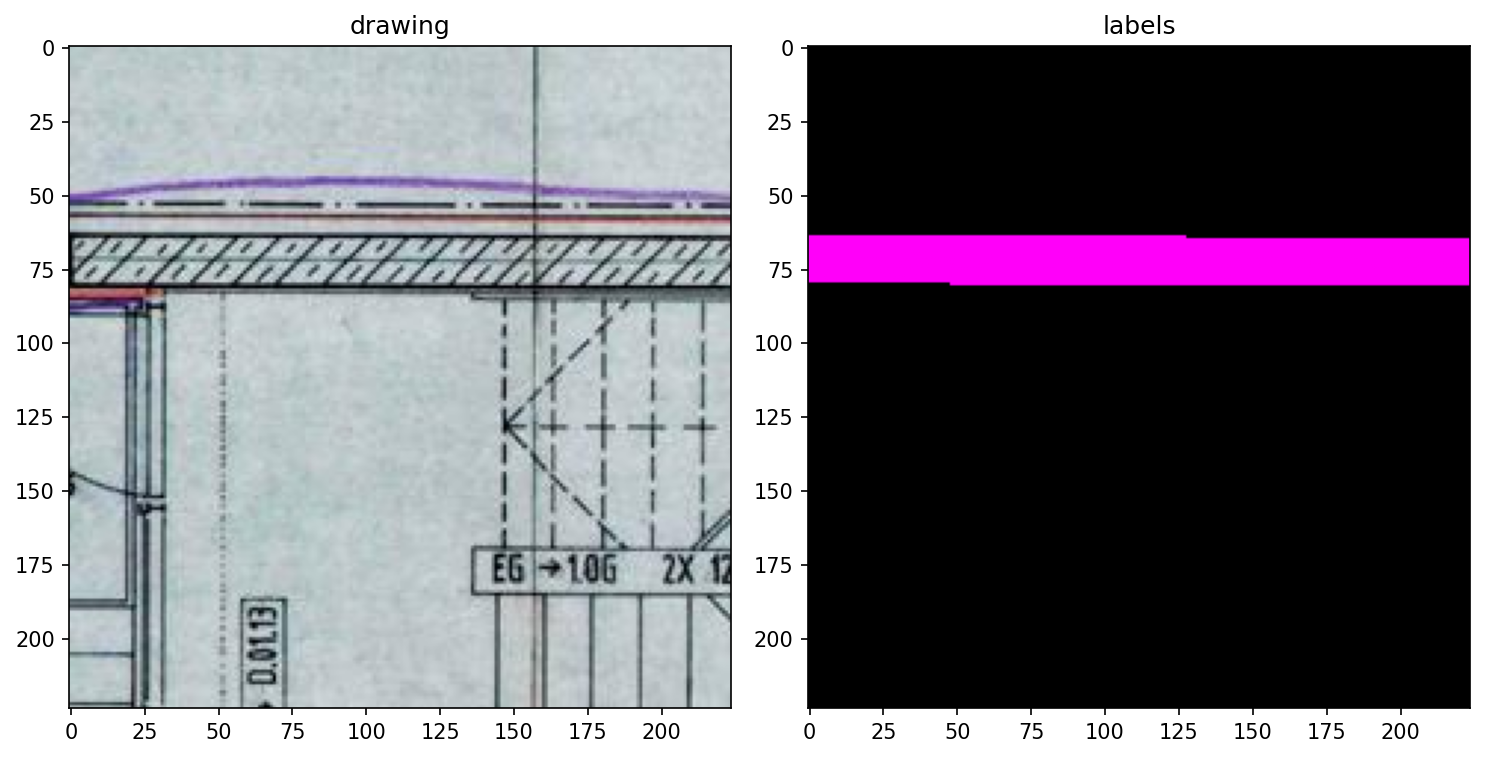

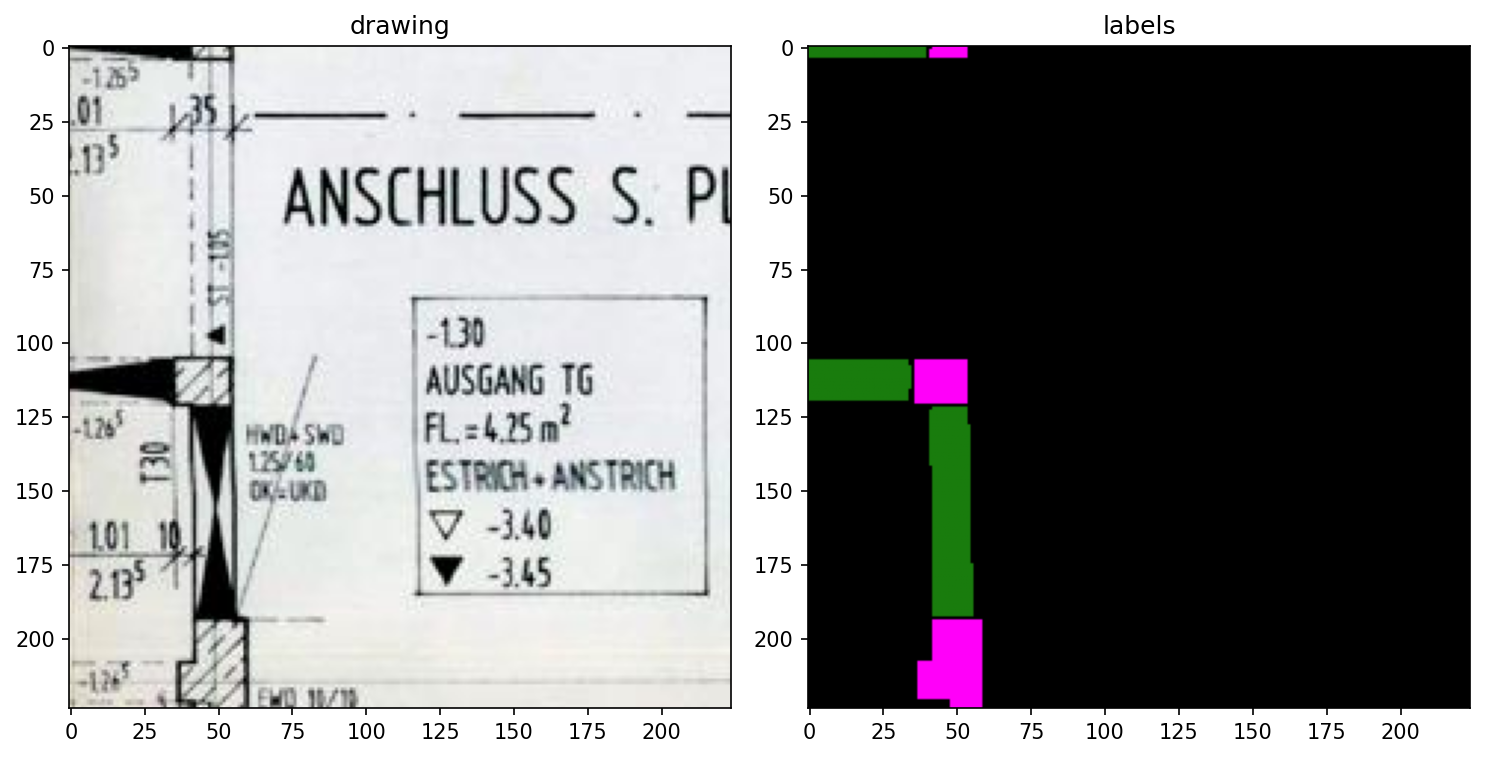

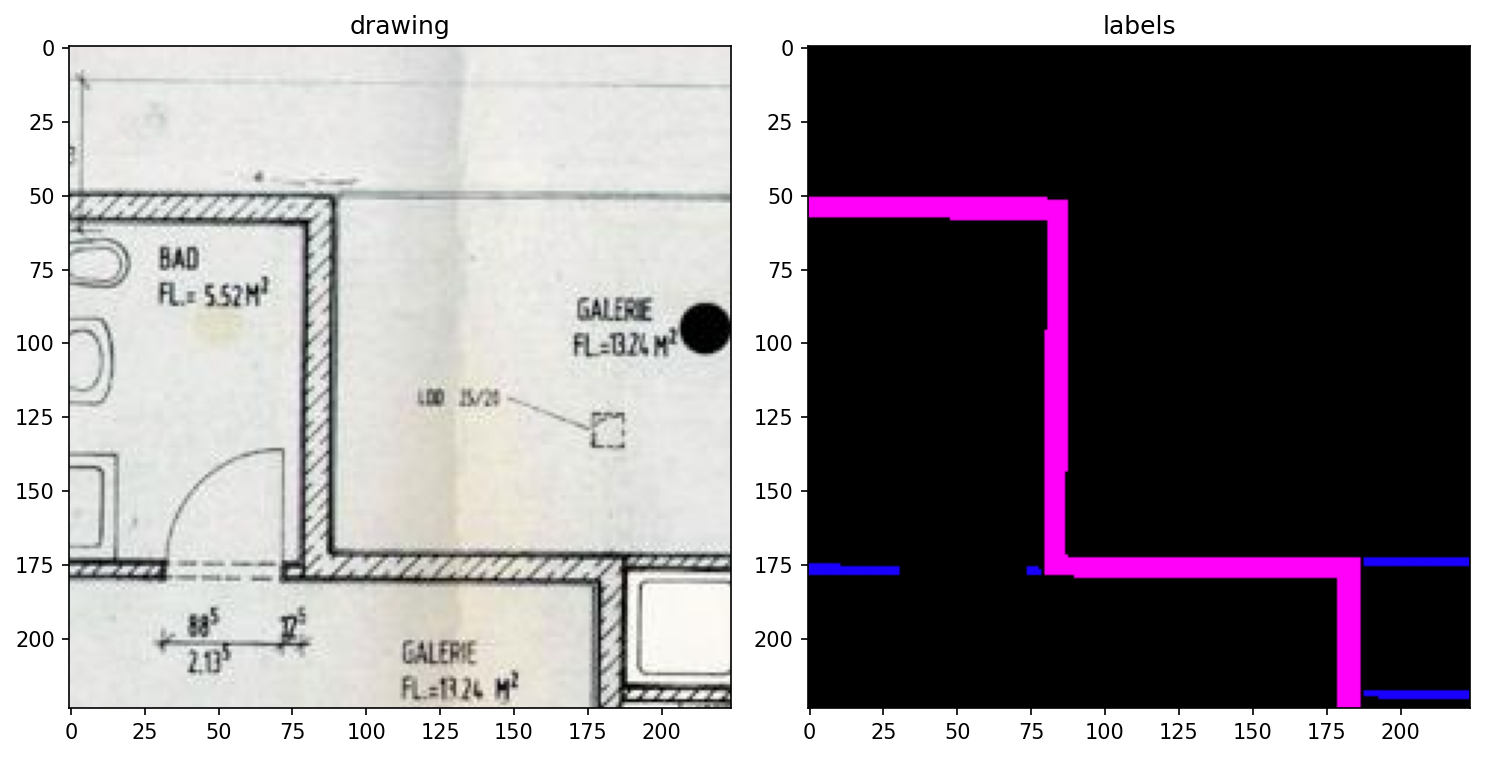

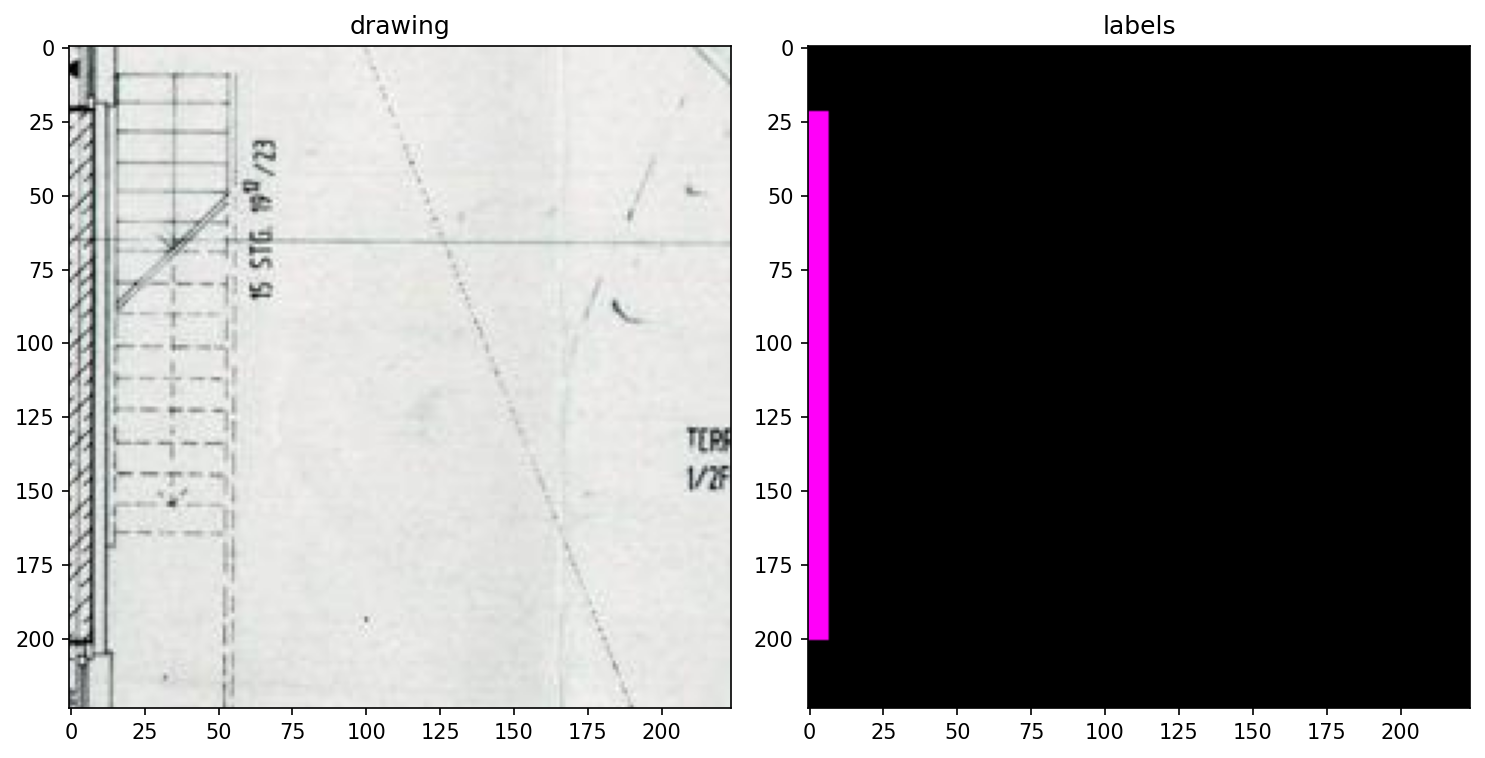

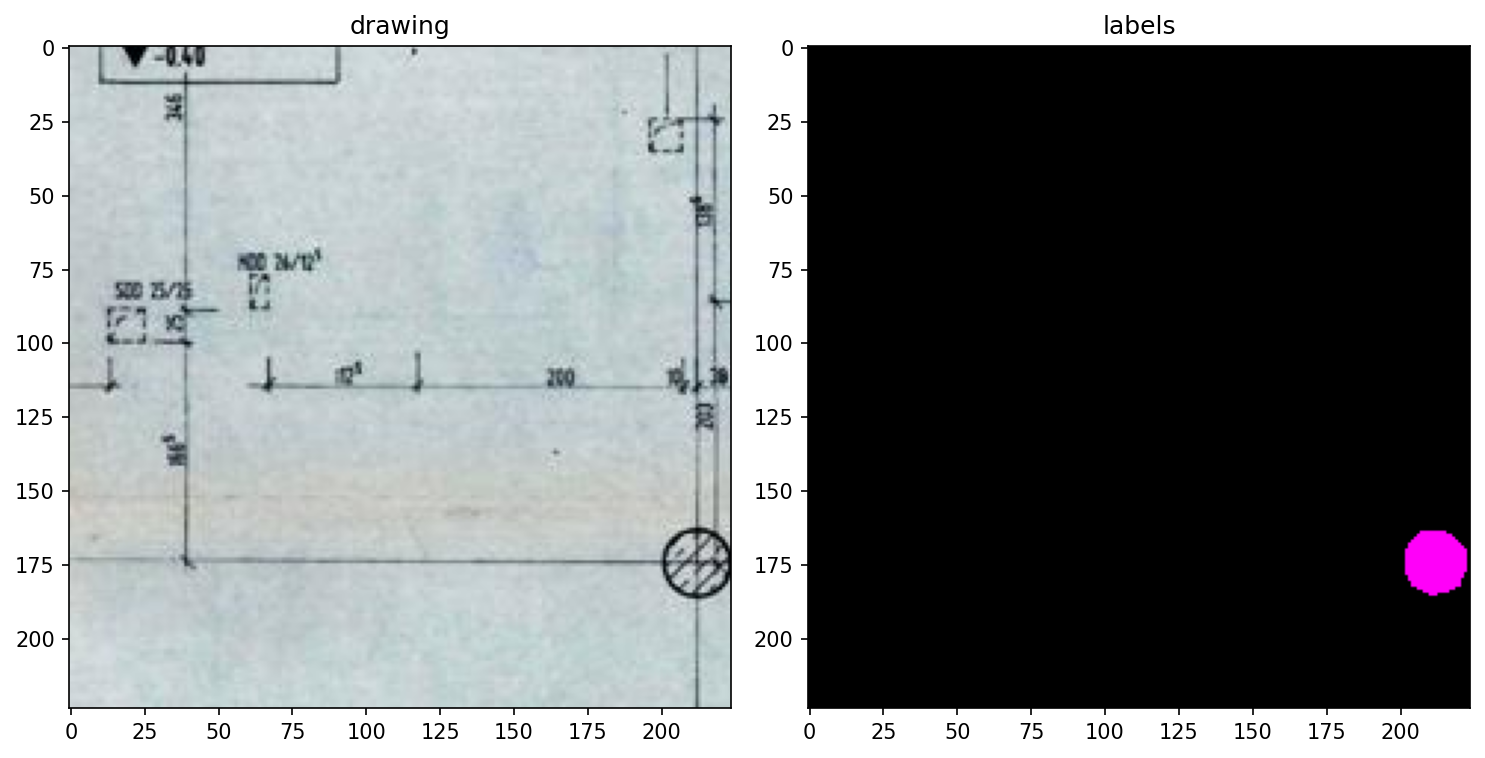

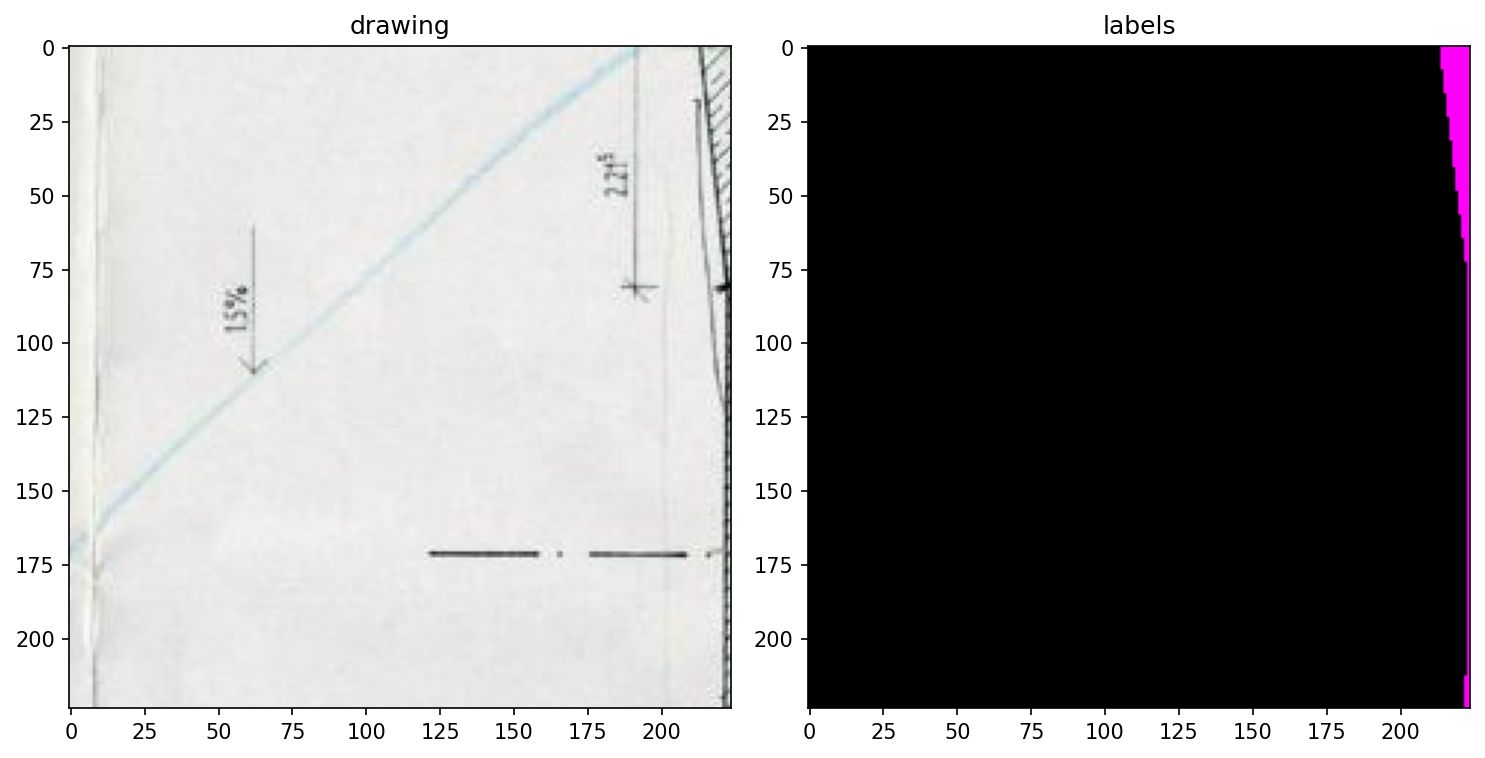

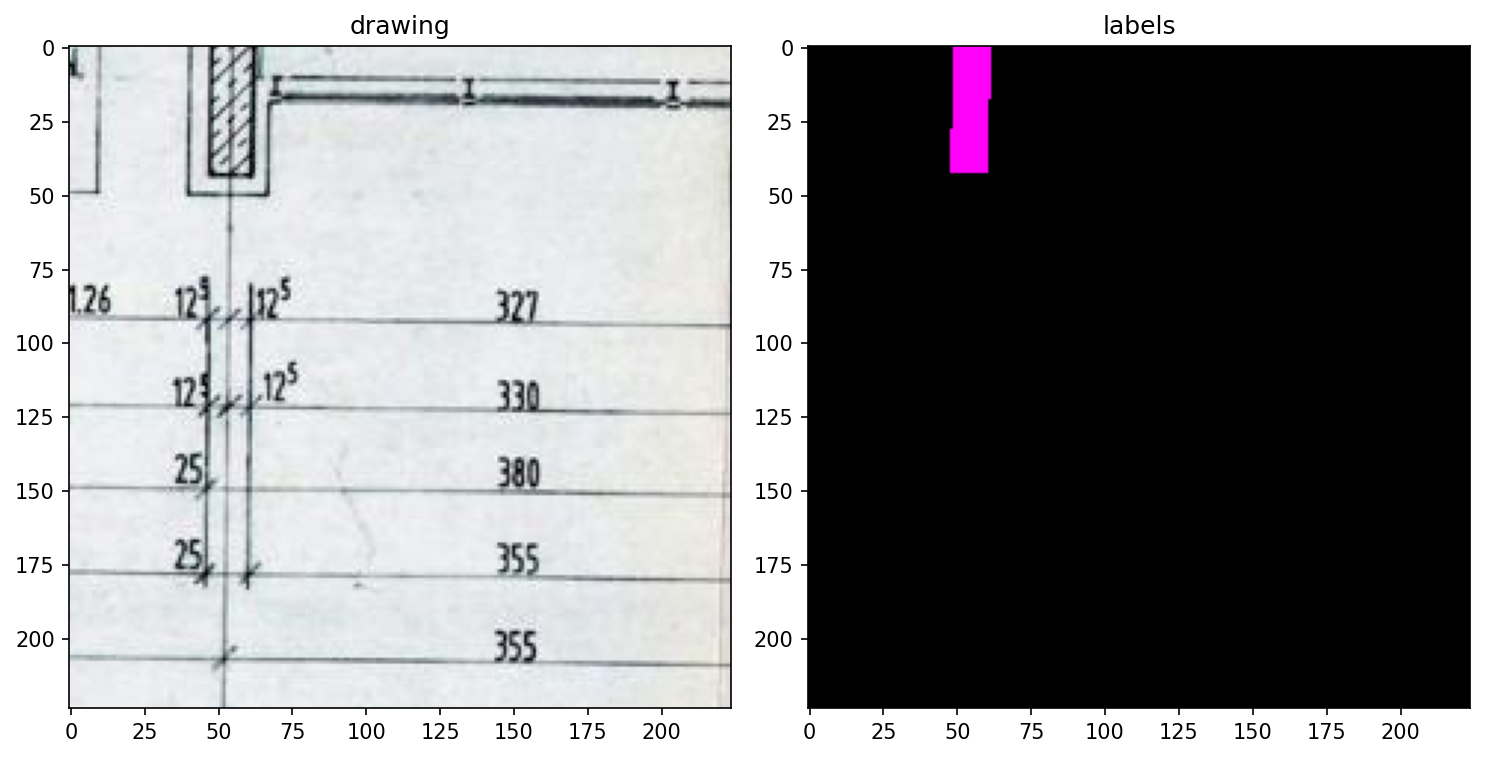

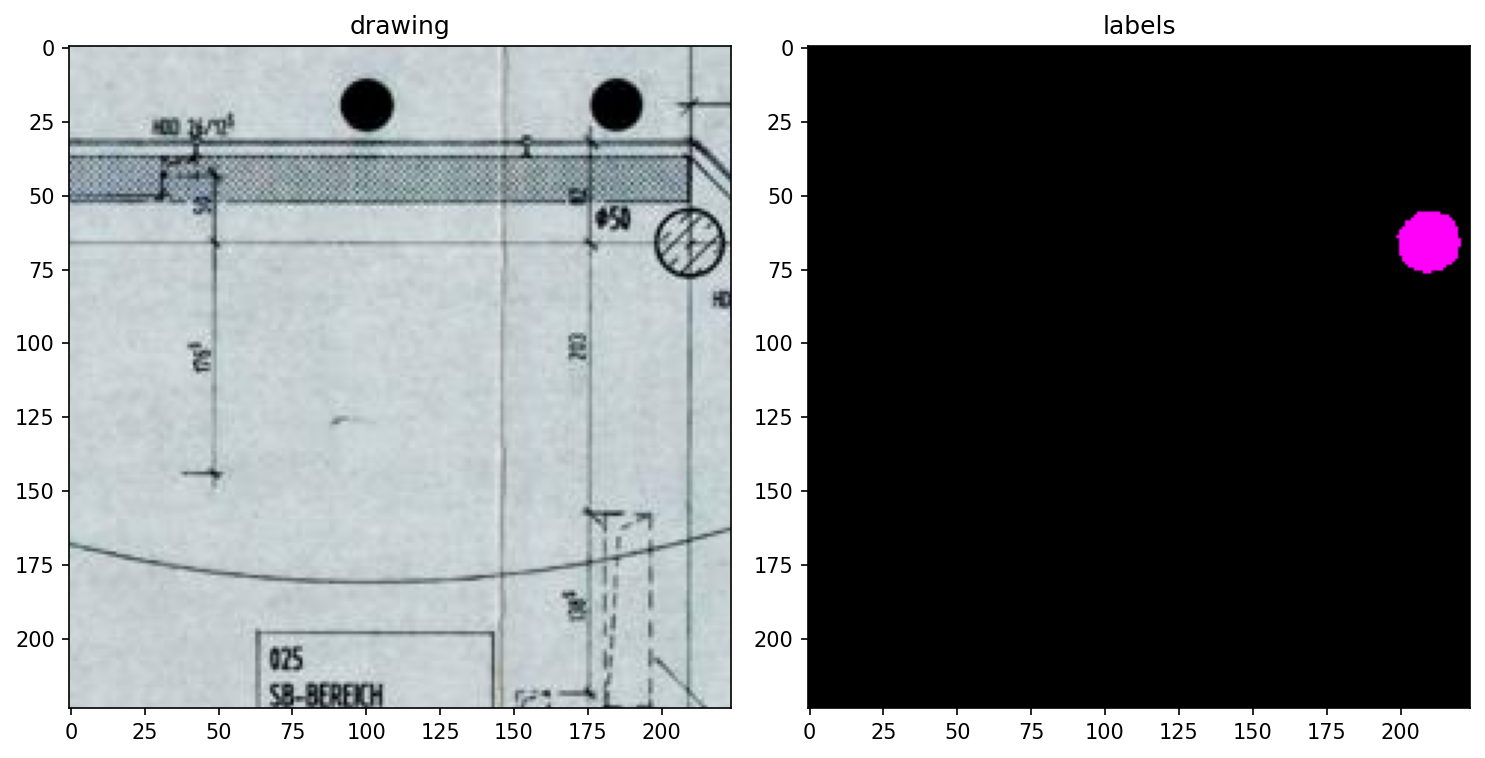

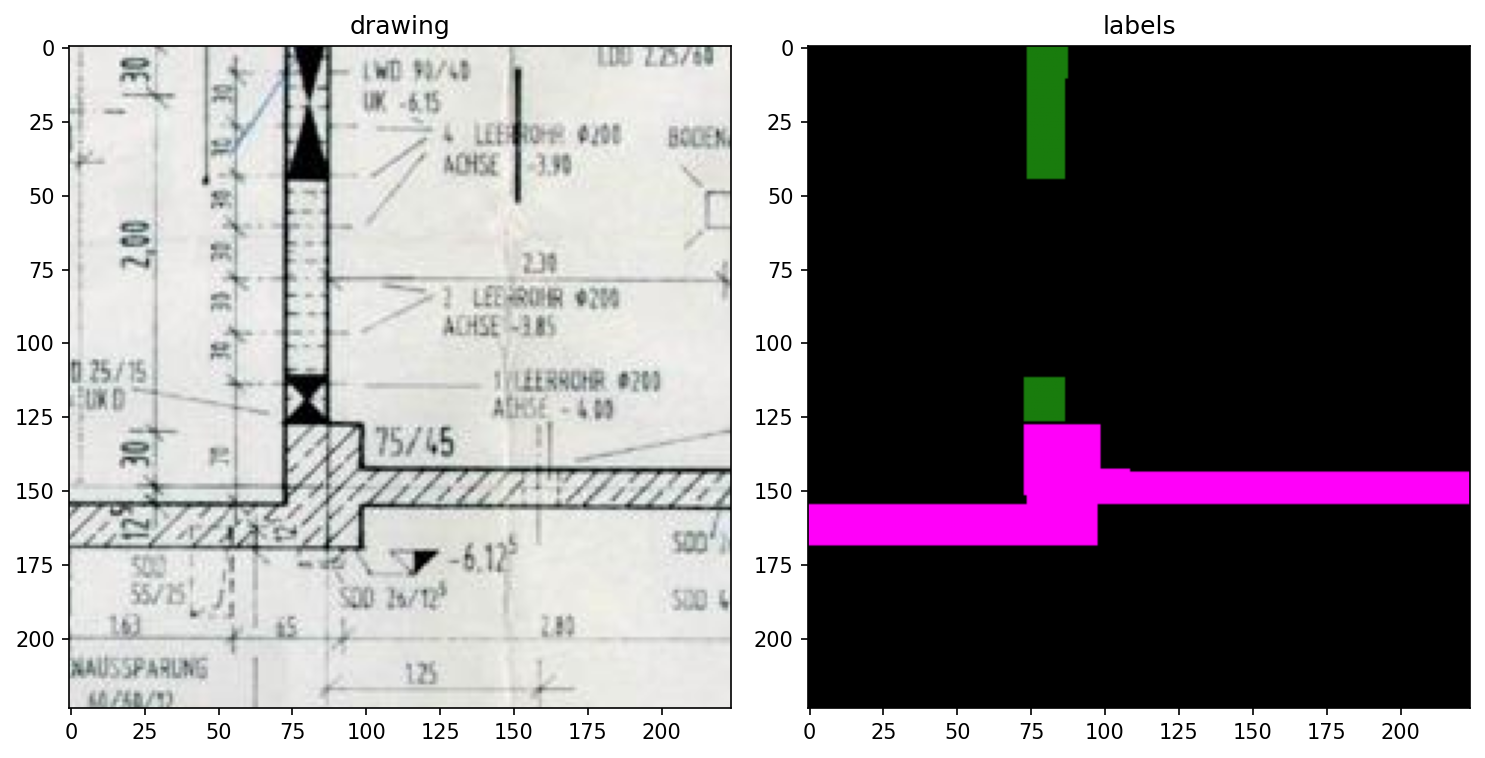

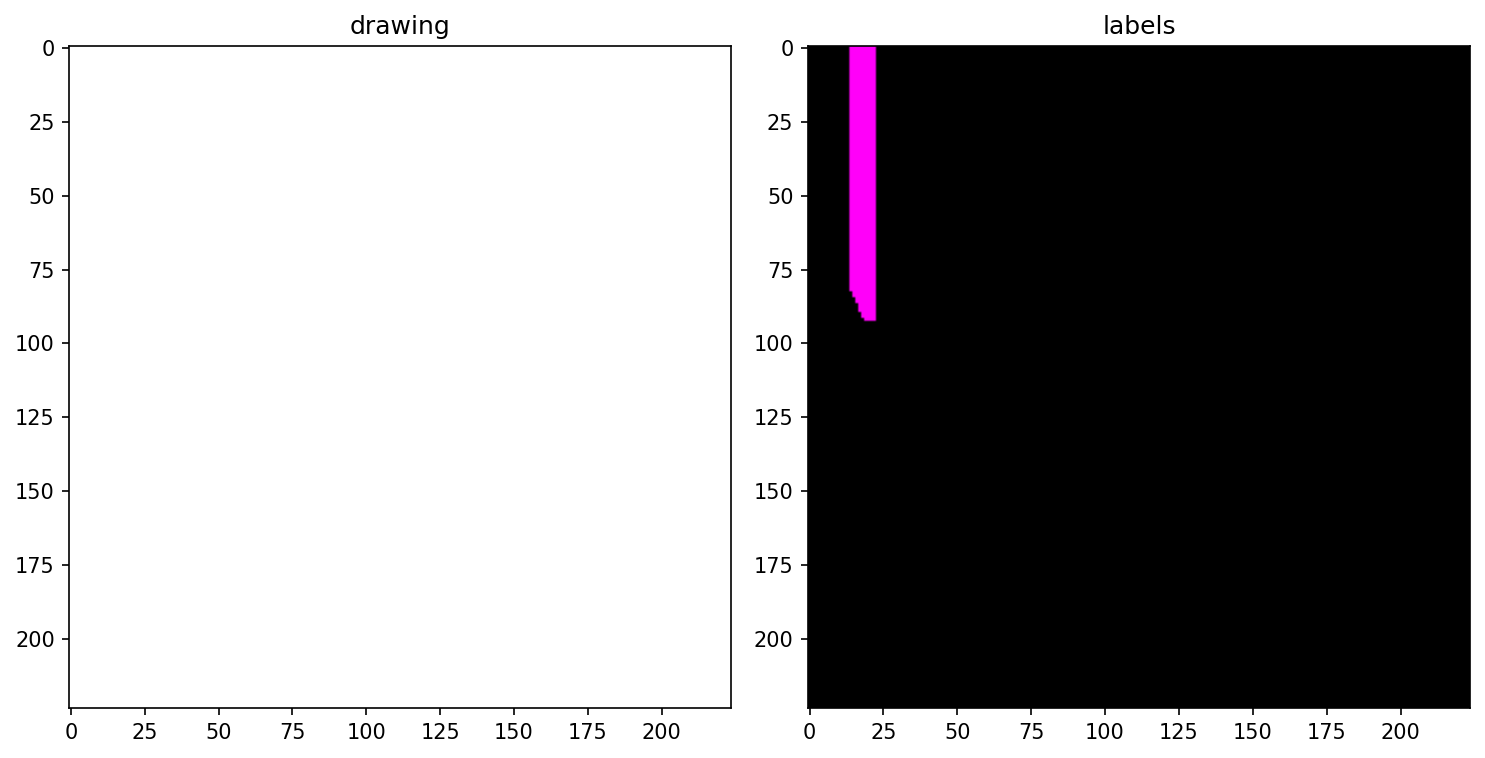

In [31]:
# check the results
i = 2
anno_dirs = sorted(glob(join(target_root, '*', 'anno')))
image_dirs = sorted(glob(join(target_root, '*', 'images')))
anno_dir = anno_dirs[i]
image_dir = image_dirs[i]

anno_images = sorted(glob(join(anno_dir, '*.png')))
drawing_imgs = sorted(glob(join(image_dir, '*.jpg')))

for rand_i in np.random.choice(range(len(anno_images)), 10, replace=False):
    assert splitext(basename(drawing_imgs[rand_i]))[0] == splitext(basename(anno_images[rand_i]))[0]
    drawing = Image.open(drawing_imgs[rand_i])
    drawing_np = np.asarray(drawing)
    anno = Image.open(anno_images[rand_i])
    anno_np = np.asarray(anno)
    fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=150)
    axs[0].imshow(drawing_np)
    axs[0].set_title('drawing')
    # axs[1].matshow(anno_np, vmin=0, vmax=8, cmap='jet')
    axs[1].imshow(anno_np, vmin=0, vmax=8, cmap=cmap_material)
    axs[1].set_title('labels')
    plt.tight_layout()

In [32]:
# notes
# the tile size appear to be like 650px

In [33]:
len(anno_images)

687

In [34]:
len(drawing_imgs)

687